In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import stats
from matplotlib import pyplot as plt
from datetime import datetime
from datetime import timedelta
from scipy import stats
from sklearn.metrics import r2_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/madisondailyweather/USW00014837.csv
/kaggle/input/seatac-daily-weather/USW00024233.csv


# Historical Weather

## This day is history? Weathered history? Weather Window?

Data is from Carnegie Mellon project, check citing and use agreements
https://kilthub.cmu.edu/articles/dataset/Compiled_daily_temperature_and_precipitation_data_for_the_U_S_cities/7890488

## What am I doing?

I've always wanted a way to not just check basic stats on a day in history (like the record high/low and average tempurature for May 10th in Seattle) but to see the actial districution of the tempurates in that day to see how abnormal it is. Something similar to this https://mobile.twitter.com/NWSSeattle/status/1522291531582873600?cxt=HHwWgICpiaSFoqAqAAAA like a percentile of that day. Of course with weather records going back to <150 observations in good cases, and 50-70 in most cases, it might be better to look at broader windows (rolling month? rolling two weeks?)

1. To start off I'll build a histogram of highs and lows for a day for seattle, providing a percentile for the specific day and highlighting record high and low and average. I'll expand to a broader window and more cities, perhaps making it more customizable. (also diurnal temp variation?)

2. Then I can also look at the shifting climate. This can be done by comparing the histogram for the first and second half of the available records for a date or window (significance test??? Compating locations???), or plotting average tempurature for that window over the years.

Also can do 1. and 2. for precipitation in window, compare wetness of period to past and see how precipitation patterns have changed over the years.

Done before things include plotting weather over a year over the years, plotting average tempurate over the years. More insputation can be found in the paper based on the dataset here https://journals.ametsoc.org/view/journals/clim/32/14/jcli-d-18-0630.1.xml

## 0. Quick Look

In [2]:
# Loading the data

data = pd.read_csv('../input/seatac-daily-weather/USW00024233.csv')
#data = pd.read_csv('../input/madisondailyweather/USW00014837.csv')

In [3]:
# Adding year/month/day column for easier manipulation and grouping

data['Date'] = pd.to_datetime(data['Date'])
data.drop(['Unnamed: 0'], axis=1, inplace=True)
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month
data['day'] = data['Date'].dt.day
data.head()

,Date,tmax,tmin,prcp,year,month,day
0,1894-01-01,40.0,36.0,0.13,1894,1,1
1,1894-01-02,40.0,35.0,0.00,1894,1,2
2,1894-01-03,38.0,30.0,0.04,1894,1,3
3,1894-01-04,36.0,28.0,0.06,1894,1,4
4,1894-01-05,37.0,22.0,0.01,1894,1,5


In [4]:
data.describe()

,tmax,tmin,prcp,year,month,day
count,46732.000000,46720.000000,46736.000000,46751.000000,46751.000000,46751.000000
mean,59.274608,44.851451,0.098923,1957.501572,6.523026,15.729353
std,12.459738,8.678032,0.227003,36.949114,3.448714,8.800066
min,16.000000,0.000000,0.000000,1894.000000,1.000000,1.000000
25%,50.000000,39.000000,0.000000,1926.000000,4.000000,8.000000
50%,58.000000,45.000000,0.000000,1958.000000,7.000000,16.000000
75%,68.000000,52.000000,0.090000,1989.500000,10.000000,23.000000
max,108.000000,73.000000,5.020000,2021.000000,12.000000,31.000000


In [5]:
# Handeling the small amount for NAs

data.isna().sum()

Date      0
tmax     19
tmin     31
prcp     15
year      0
month     0
day       0
dtype: int64

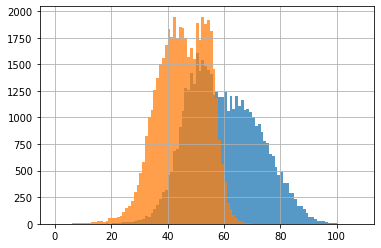

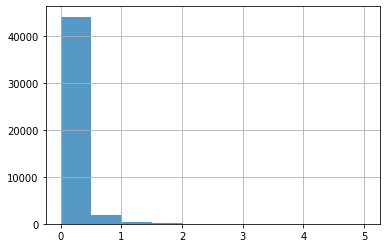

In [6]:
# All days

# Can change bins to be min/max of data instead of hard coded
seattle_bins = np.arange(int(data.tmin.min()), int(data.tmax.max()+1), 1)

# Hist of all days
data.tmax.hist(bins=seattle_bins,alpha=0.75)
data.tmin.hist(bins=seattle_bins,alpha=0.75)
plt.show()

# Hist of rainfall
data.prcp.hist(alpha=0.75)
plt.show()

## 1. Day in history

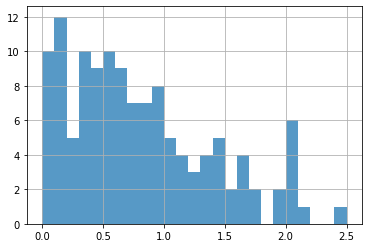

In [8]:
# Looking at rain windows

date = datetime(2020, 5, 24)

window = data[(data['month'] == date.month) \
                  & (data['day'] >= (date.day - 7)) \
                  & (data['day'] <= (date.day + 7))]

total_rain = window.groupby('year').sum()['prcp']
window_rain_bins = np.arange(0, round(max(total_rain) + 0.1,1), 0.1)
total_rain.hist(bins=window_rain_bins, alpha=0.75)
plt.show()

In [9]:
# Window history
def plot_window(date, high, low):
    # Getting the data (need to change to actual datetime stuff for window)
    window = data[(data['month'] == date.month) \
                  & (data['day'] >= (date.day - 7)) \
                  & (data['day'] <= (date.day + 7))]
    
    # Can change bins to be min/max of data instead of hard coded
    sea_may_bins = np.arange(window.tmin.min(), window.tmax.max() + 1, 1)
    
    # Plotting distribution for high
    window.tmax.hist(bins=sea_may_bins,alpha=0.75, color='r')
    # Today's high and percentile
    plt.axvline(high, color='k', linestyle='dashed', linewidth=1)
    min_ylim, max_ylim = plt.ylim()
    plt.text(high*0.98, max_ylim*0.9, 'Today\'s High: {:.1f}'.format(high), ha='right')
    plt.text(high*0.98, max_ylim*0.8, 'Percentile: {:.1f}'.format(stats.stats.percentileofscore(window.tmax, high, 'mean')), ha='right')
    # All time 
    #plt.text(window.tmax.max(), max_ylim*0.1, 'All Time High: {:.1f}'.format(window.tmax.max()), ha='center')
    #plt.text(window.tmax.min(), max_ylim*0.1, 'Lowest High: {:.1f}'.format(window.tmax.min()), ha='center')
    # Finishing touches
    plt.grid(axis = 'y')
    plt.xlabel("Temperature (F)")
    plt.ylabel("Occurrences")
    plt.title("Daily highs for %d-%d to %d-%d" %(date.month,date.day-7,date.month,date.day+7))
    plt.show()
    
    # Plotting distribution for lows
    window.tmin.hist(bins=sea_may_bins,alpha=0.75, color='b')
    # Today's low and percentile
    plt.axvline(low, color='k', linestyle='dashed', linewidth=1)
    min_ylim, max_ylim = plt.ylim()
    plt.text(low*1.02, max_ylim*0.9, 'Today\'s Low: {:.1f}'.format(low))
    plt.text(low*1.02, max_ylim*0.8, 'Percentile: {:.1f}'.format(100 - stats.stats.percentileofscore(window.tmin, low, 'mean')))
    # All time 
    #plt.text(window.tmin.min(), max_ylim*0.1, 'All Time Low: {:.1f}'.format(window.tmin.min()), ha='center')
    #plt.text(window.tmin.max(), max_ylim*0.1, 'Highest Low: {:.1f}'.format(window.tmin.max()), ha='center')
    # Finishing touches
    plt.grid(axis = 'y')
    plt.xlabel("Temperature (F)")
    plt.ylabel("Occurrences")
    plt.title("Daily lows for %d-%d to %d-%d" %(date.month,date.day-7,date.month,date.day+7))
    plt.show()
    
    # Plotting distribution for diurnal window
    diurnal = high - low
    diurnal_all = window.tmax - window.tmin
    plt.hist(diurnal_all, bins = np.arange(diurnal_all.min(), diurnal_all.max() + 1, 1), alpha=0.75, color='g')
    # Today's diurnal and percentile
    plt.axvline(diurnal, color='k', linestyle='dashed', linewidth=1)
    min_ylim, max_ylim = plt.ylim()
    plt.text(diurnal*1.05, max_ylim*0.9, 'Today\'s Variation: {:.1f}'.format(diurnal))
    plt.text(diurnal*1.05, max_ylim*0.8, 'Percentile: {:.1f}'.format(stats.stats.percentileofscore(diurnal_all, diurnal, 'mean')))
    # All time 
    #plt.text(diurnal_all.min(), max_ylim*0.1, 'All Time Smallest: {:.1f}'.format(diurnal_all.min()), ha='center')
    #plt.text(diurnal_all.max(), max_ylim*0.1, 'All Tiem Largest: {:.1f}'.format(diurnal_all.max()), ha='center')
    # Finishing touches
    plt.grid(axis = 'y')
    plt.xlabel("Diurnal Variation (F)")
    plt.ylabel("Occurrences")
    plt.title("Diurnal variation for %d-%d to %d-%d" %(date.month,date.day-7,date.month,date.day+7))
    plt.show()

In [19]:
# Window in history
def plot_trend(date, high, low):
    # Getting the data (need to change to actual datetime stuff for window)
    window = data[(data['month'] == date.month) \
                  & (data['day'] >= (date.day - 7)) \
                  & (data['day'] <= (date.day + 7))]
    
    # Plotting average low and high over the years
    mins = window.groupby('year').mean()['tmin'].reset_index()
    maxs = window.groupby('year').mean()['tmax'].reset_index()
    plt.scatter(mins['year'], mins['tmin'], c='b')
    plt.scatter(maxs['year'], maxs['tmax'], c='r')
    
    # lines of best fit
    z = np.polyfit(mins['year'], mins['tmin'], 1)
    p = np.poly1d(z)
    plt.plot(mins['year'], p(mins['year']), color="gray", linewidth=3, linestyle="--")
    plt.annotate("r-squared = {:.3f}".format(r2_score(mins['tmin'], p(mins['year']))), (1900, 38))
    plt.annotate("slope = {:.3f}".format(z[0]), (1900, 33))
    
    z = np.polyfit(maxs['year'], maxs['tmax'], 1)
    p = np.poly1d(z)
    plt.plot(maxs['year'], p(maxs['year']), color="gray", linewidth=3, linestyle="--")
    plt.annotate("r-squared = {:.3f}".format(r2_score(maxs['tmax'], p(maxs['year']))), (1900, 82))
    plt.annotate("slope = {:.3f}".format(z[0]), (1900, 78))
    
    plt.ylim([30, 90])
    plt.title("Average temperature for %d-%d to %d-%d over the years" %(date.month,date.day-7,date.month,date.day+7))
    plt.ylabel("Temperature (F)")
    plt.xlabel("Year")
    plt.show()
    
    # Diurnal variation
    diurnal = maxs['tmax'] - mins['tmin']
    diurnal_years = maxs['year']
    plt.scatter(diurnal_years, diurnal, c='b')
    
    z = np.polyfit(diurnal_years, diurnal, 1)
    p = np.poly1d(z)
    plt.plot(diurnal_years, p(diurnal_years), color="gray", linewidth=3, linestyle="--")
    plt.annotate("r-squared = {:.3f}".format(r2_score(diurnal, p(diurnal_years))), (1900, 25))
    plt.annotate("slope = {:.3f}".format(z[0]), (1900, 24))
    
    plt.ylim([10, 28])
    plt.title("Diurnal Variation for %d-%d to %d-%d over the years" %(date.month,date.day-7,date.month,date.day+7))
    plt.ylabel("Variation (F)")
    plt.xlabel("Year")
    plt.show()
    
    # Rainfall
    prcp = window.groupby('year').sum()['prcp'].reset_index()
    plt.scatter(prcp['year'], prcp['prcp'], c='b')
    
    z = np.polyfit(prcp['year'], prcp['prcp'], 1)
    p = np.poly1d(z)
    plt.plot(prcp['year'], p(prcp['year']), color="gray", linewidth=3, linestyle="--")
    plt.annotate("r-squared = {:.3f}".format(r2_score(prcp['prcp'], p(prcp['year']))), (1900, 2.8))
    plt.annotate("slope = {:.3f}".format(z[0]), (1900, 2.5))
    
    plt.ylim([0, 3])
    plt.title("Total Rainfall for %d-%d to %d-%d over the years" %(date.month,date.day-7,date.month,date.day+7))
    plt.ylabel("Rainfall (Inches)")
    plt.xlabel("Year")
    plt.show()

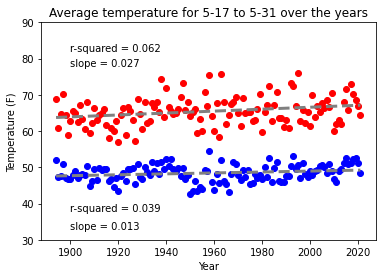

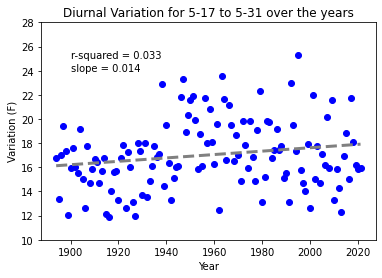

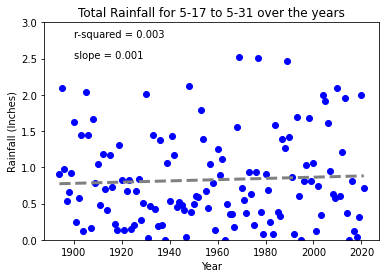

In [20]:
plot_trend(date, high, low)

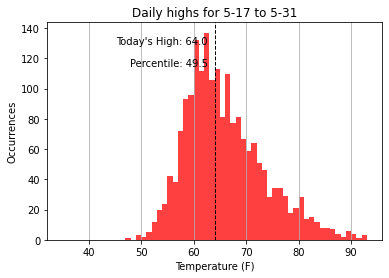

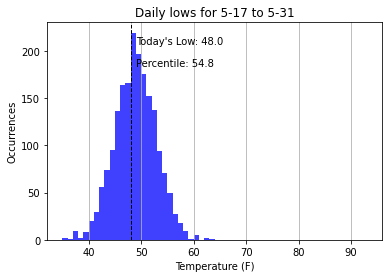

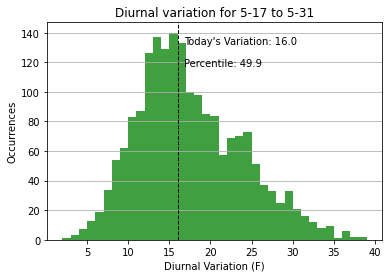

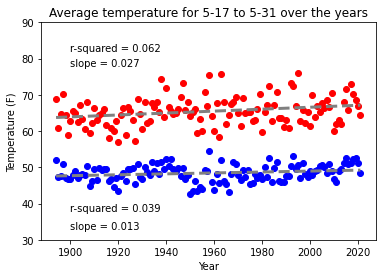

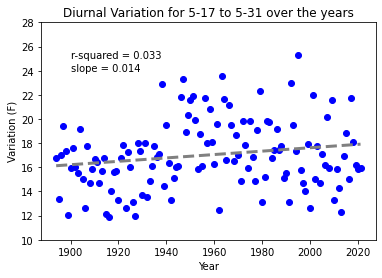

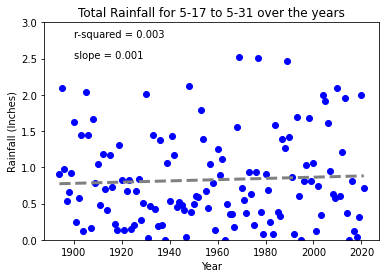

In [11]:
# input
date = datetime(2020, 5, 24)
high = 64
low = 48

# Plotting
plot_window(date, high, low)

plot_trend(date, high, low)

## 2. Change over the years

In [21]:
pre_1957 = data[(data['year'] < 1957)]
on_1957 = data[(data['year'] >= 1957)]

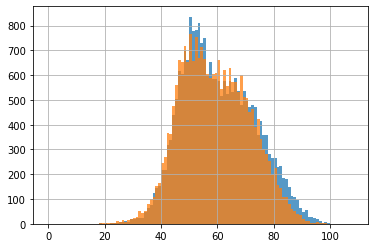

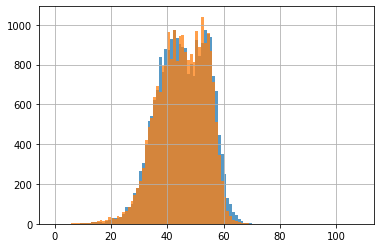

Highs
58.599338900487126 59.92860151642797
Ttest_indResult(statistic=11.546154823340252, pvalue=8.500312921830947e-31)
Lows
44.64064403829417 45.05550968828981
Ttest_indResult(statistic=5.1673705980014955, pvalue=2.3838453070116338e-07)
Precip
0.09228120516499283 0.1053595955340215
Ttest_indResult(statistic=6.229308446597815, pvalue=4.724794340608693e-10)


In [22]:
# All high compared between halves
on_1957.tmax.hist(bins=seattle_bins, alpha=0.75)
pre_1957.tmax.hist(bins=seattle_bins, alpha=0.75)
plt.show()

# All low compared between halves
on_1957.tmin.hist(bins=seattle_bins, alpha=0.75)
pre_1957.tmin.hist(bins=seattle_bins, alpha=0.75)
plt.show()

# Significance in differences
print('Highs')
print(pre_1957.tmax.dropna().mean(), on_1957.tmax.dropna().mean())
print(stats.ttest_ind(on_1957.tmax.dropna(), pre_1957.tmax.dropna()))
print('Lows')
print(pre_1957.tmin.dropna().mean(), on_1957.tmin.dropna().mean())
print(stats.ttest_ind(on_1957.tmin.dropna(), pre_1957.tmin.dropna()))
print('Precip')
print(pre_1957.prcp.dropna().mean(), on_1957.prcp.dropna().mean())
print(stats.ttest_ind(on_1957.prcp.dropna(), pre_1957.prcp.dropna()))

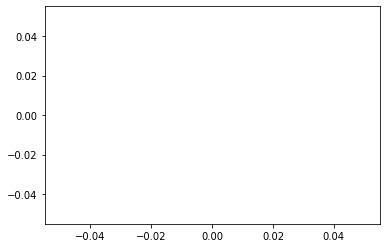

In [23]:
# Line plot of years with rolling mean, need to do something about NaNs to do this

a = np.linspace(0.1, 1, 11)
i = 0
rolling = 0
for year in range(1921, 2021, 1):
    rolling += data[data['year'] == year]['tmax'].rolling(30).mean()
    if (year%10) == 0:
        x = np.arange(1, len(rolling) + 1, 1)
        plt.plot(x, rolling/10, alpha = a[i], color = 'r')
        i += 1
        if year != 2020:
            rolling = 0